## 프로젝트 목표

---
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.	
    * 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.
2. Transformer 번역기 모델이 정상적으로 구동된다.	
    * Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.	
    * 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/User/k.010k/Library/Fonts/NanumGothicBold.otf'

In [2]:
import tensorflow as tf
import numpy as np
import os
import re
import random

import sentencepiece as spm
from tqdm import tqdm 
from utils import *

from models import Transformer, Encoder



In [3]:
# GPU가 사용 가능한 경우, 기본 디바이스를 GPU로 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')  # 첫 번째 GPU만 사용
        tf.config.experimental.set_memory_growth(gpus[0], True)  # 필요할 때만 GPU 메모리 사용
    except RuntimeError as e:
        print(e)

print("✅ GPU 활성화됨:", tf.config.list_physical_devices('GPU'))

✅ GPU 활성화됨: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 데이터 정제 및 토큰화

---
1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거
2. 정제 함수 정의
3. Sentencepiece 이용한 토큰화
4. 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"


kor_corpus = read_data(kor_path)
eng_corpus = read_data(eng_path)


In [5]:
print(len(kor_corpus))
print(len(eng_corpus))

94123
94123


In [6]:
# 데이터 중복 제거
unique_pairs = set(zip(kor_corpus, eng_corpus))
corpus_train = list(unique_pairs)

In [7]:
print(len(corpus_train))

78968


In [8]:
kor_corpus = []
eng_corpus = []

for pair in corpus_train:
    kor, eng = pair[0], pair[1]
    kor_preprocessed = preprocess_kor(kor)
    eng_preprocessed = preprocess_eng(eng)
    kor_corpus.append(kor_preprocessed)
    eng_corpus.append(eng_preprocessed)

print("한국어:", kor_corpus[1100])
print("영어:", eng_corpus[1100])

print(len(kor_corpus))
print(len(eng_corpus))

한국어: 또 레이크카운티 인근에는 코노크티 화산이 있다 코노크티 화산은 레이크카운티의 상징으로서 수천 피트 높이에서 호수를 감상할 수도 있는 매력을 지니고 있다
영어: he tells us how to use mt konocti the once active volcano that looms several thousand feet above the lake as a landmark and invites us to call his cell phone if we lose our bearings
78968
78968


In [9]:
import re
import sentencepiece as spm
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, vocab_size, lang, pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    model_prefix = f"{lang}_tokenizer"
    
    # 임시 파일 생성
    import tempfile
    with tempfile.NamedTemporaryFile(delete=False, mode='w', encoding='utf-8') as temp_file:
        temp_path = temp_file.name
        for sentence in corpus:
            temp_file.write(sentence + '\n')
    
    # 토크나이저 학습
    spm.SentencePieceTrainer.train(
            input=temp_path,
            model_prefix=model_prefix,
            vocab_size=vocab_size,
            pad_id=pad_id,
            bos_id=bos_id,
            eos_id=eos_id,
            unk_id=unk_id,
            user_defined_symbols=["<PAD>", "<BOS>", "<EOS>", "<UNK>"],
            model_type="unigram",
            num_threads=4)
    
    # 임시 파일 삭제 (선택 사항)
    import os
    os.remove(temp_path)
    
    # 토크나이저 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{model_prefix}.model")
    
    return tokenizer

    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000


ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /tmp/tmpre8ab7y3
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 4
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <PAD>
  user_defined_symbols: <BOS>
  user_defined_symbols: <EOS>
  user_defined_symbols: <UNK>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piec

True

In [10]:
print(len(eng_corpus))

78968


In [11]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    # 각각 토크나이저로 인덱스
    src_line = ko_tokenizer.encode_as_ids(kor_corpus[idx])
    tgt_line = en_tokenizer.encode_as_ids(eng_corpus[idx])

    # 길이 필터링(50이하)
    if len(src_line) <=50 and len(tgt_line) <=50:
        src_corpus.append(src_line)
        tgt_corpus.append(tgt_line)  
    
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [12]:
print(len(src_corpus))
print(len(tgt_corpus))

76377
76377


In [13]:
def check_indices(tokenizer, num_indices=4):
    print("Checking first", num_indices, "indices")
    for i in range(num_indices):
        token = tokenizer.id_to_piece(i)
        print(f"ID {i}: {token}")

check_indices(ko_tokenizer, 4)
check_indices(en_tokenizer, 4)

Checking first 4 indices
ID 0: <pad>
ID 1: <s>
ID 2: </s>
ID 3: <unk>
Checking first 4 indices
ID 0: <pad>
ID 1: <s>
ID 2: </s>
ID 3: <unk>


In [14]:
print('한국어 토근:',src_corpus[1100])
print("\n")
print('영어 토근:',tgt_corpus[1100])

한국어 토근: [13, 3593, 810, 1056, 44, 729, 810, 1056]


영어 토근: [1, 8, 83, 94, 1249, 308, 1588, 20, 129, 307, 24, 53, 287, 51, 2555, 2]


In [15]:
ko_tokenizer.decode(src_corpus[1100])
print("\n")
en_tokenizer.decode(tgt_corpus[1100])

'the south korean ship left port on sunday night with about 20 people aboard'

In [16]:
print("enc_train shape:", enc_train.shape)
print("dec_train shape:", dec_train.shape)

enc_train shape: (76377, 50)
dec_train shape: (76377, 50)


## 모델 설계

---
**1. 마스크 생성 함수**

**2. 모델 설계**

**3. 모델 학습**


### 마스크 생성 함수

---
 1. 생성 함수
 2. 시각화

In [17]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)    
    dec_mask = generate_causality_mask(tf.shape(tgt)[1])
    dec_enc_mask = generate_padding_mask(src)

    return enc_mask, dec_enc_mask, dec_mask


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


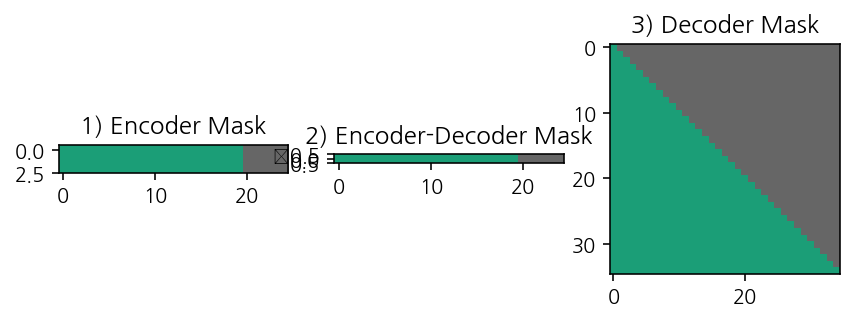

In [18]:
batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask.numpy(), cmap='Dark2')

plt.show()

### 모델 설계

---
**1.Custom Scheduler 정의**

**2.Loss(Crossentropy) 정의**

**3.Train step 정의**

In [19]:
D_MODEL = 512
transformer = Transformer(
                    n_layers=2,
                    d_model=D_MODEL,
                    n_heads=8,
                    d_ff=2048,
                    src_vocab_size= SRC_VOCAB_SIZE,
                    tgt_vocab_size= TGT_VOCAB_SIZE,
                    pos_len = 50,
                    dropout=0.2,
                    shared=True)


In [20]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step_float = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step_float)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [21]:
learning_rate = CustomSchedule(d_model=D_MODEL)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

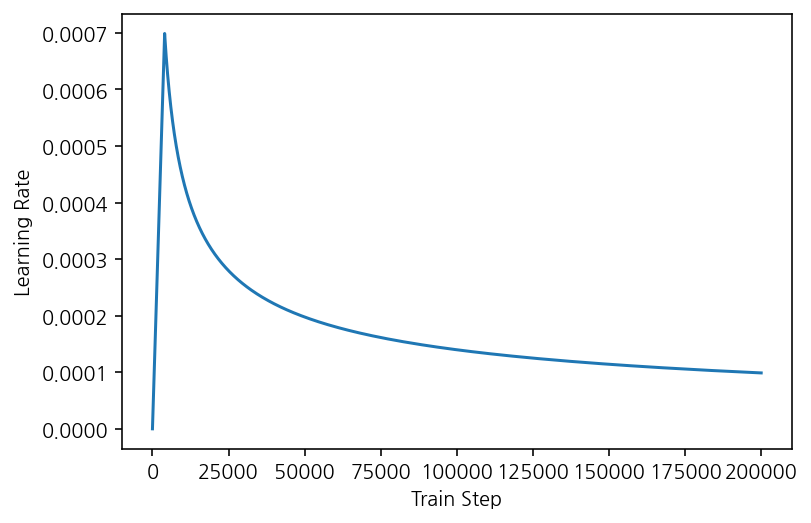

In [22]:
plt.plot(learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [23]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [24]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 모델 학습

---

In [30]:
BATCH_SIZE = 128
EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/597 [00:00<?, ?it/s]

### 평가

----

In [26]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [27]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_kor(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        batch_size = tf.shape(_input)[0]

        enc_padding_mask, dec_enc_padding_mask, combined_mask = \
            generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_enc_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [28]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

Input: 오바마는 대통령이다.
Predicted translation: president president president president president obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama
Encoder Layer 1


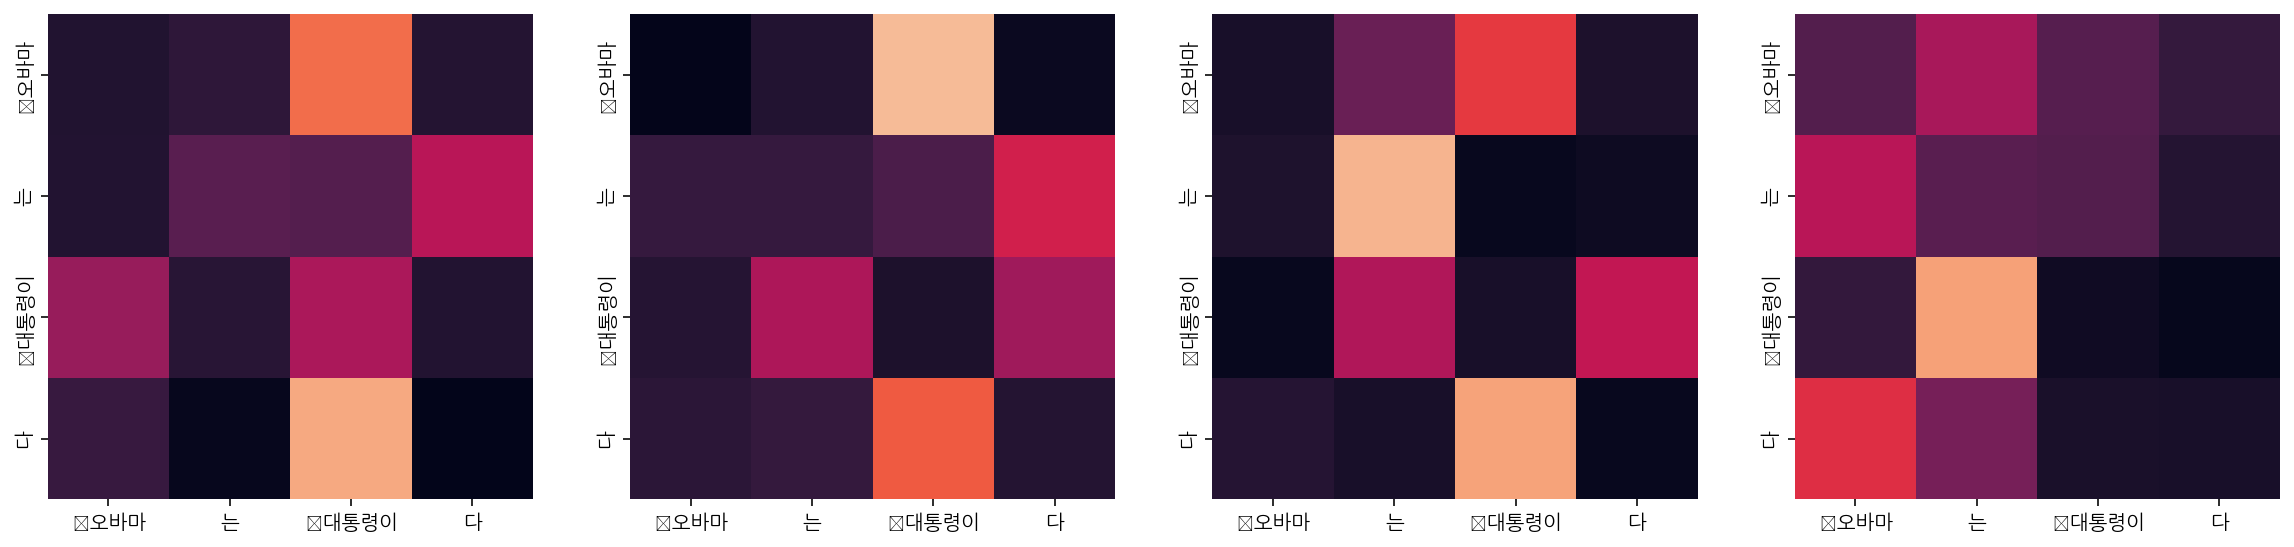

Encoder Layer 2


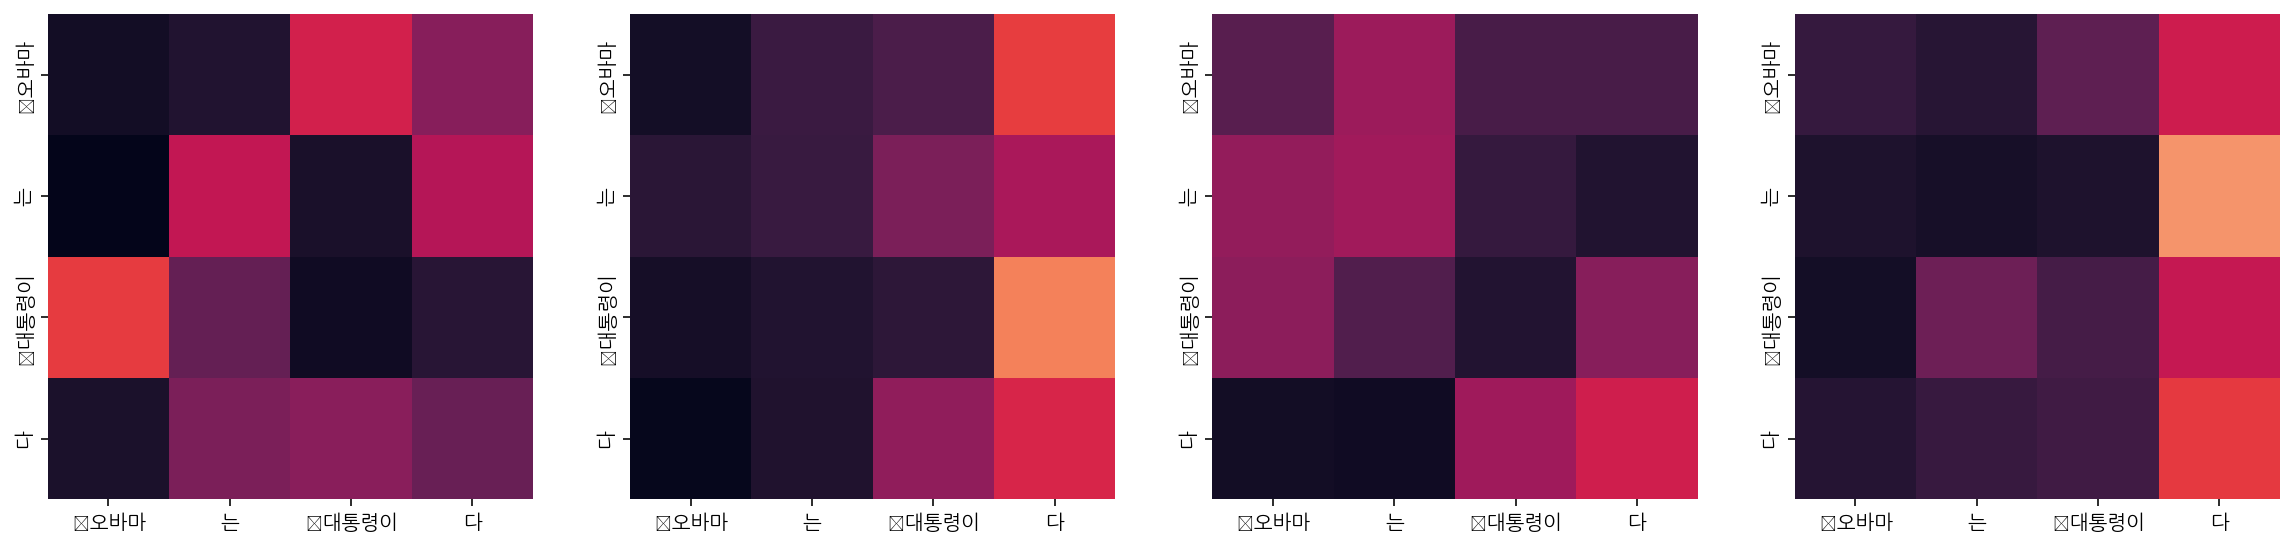

Decoder Self Layer 1


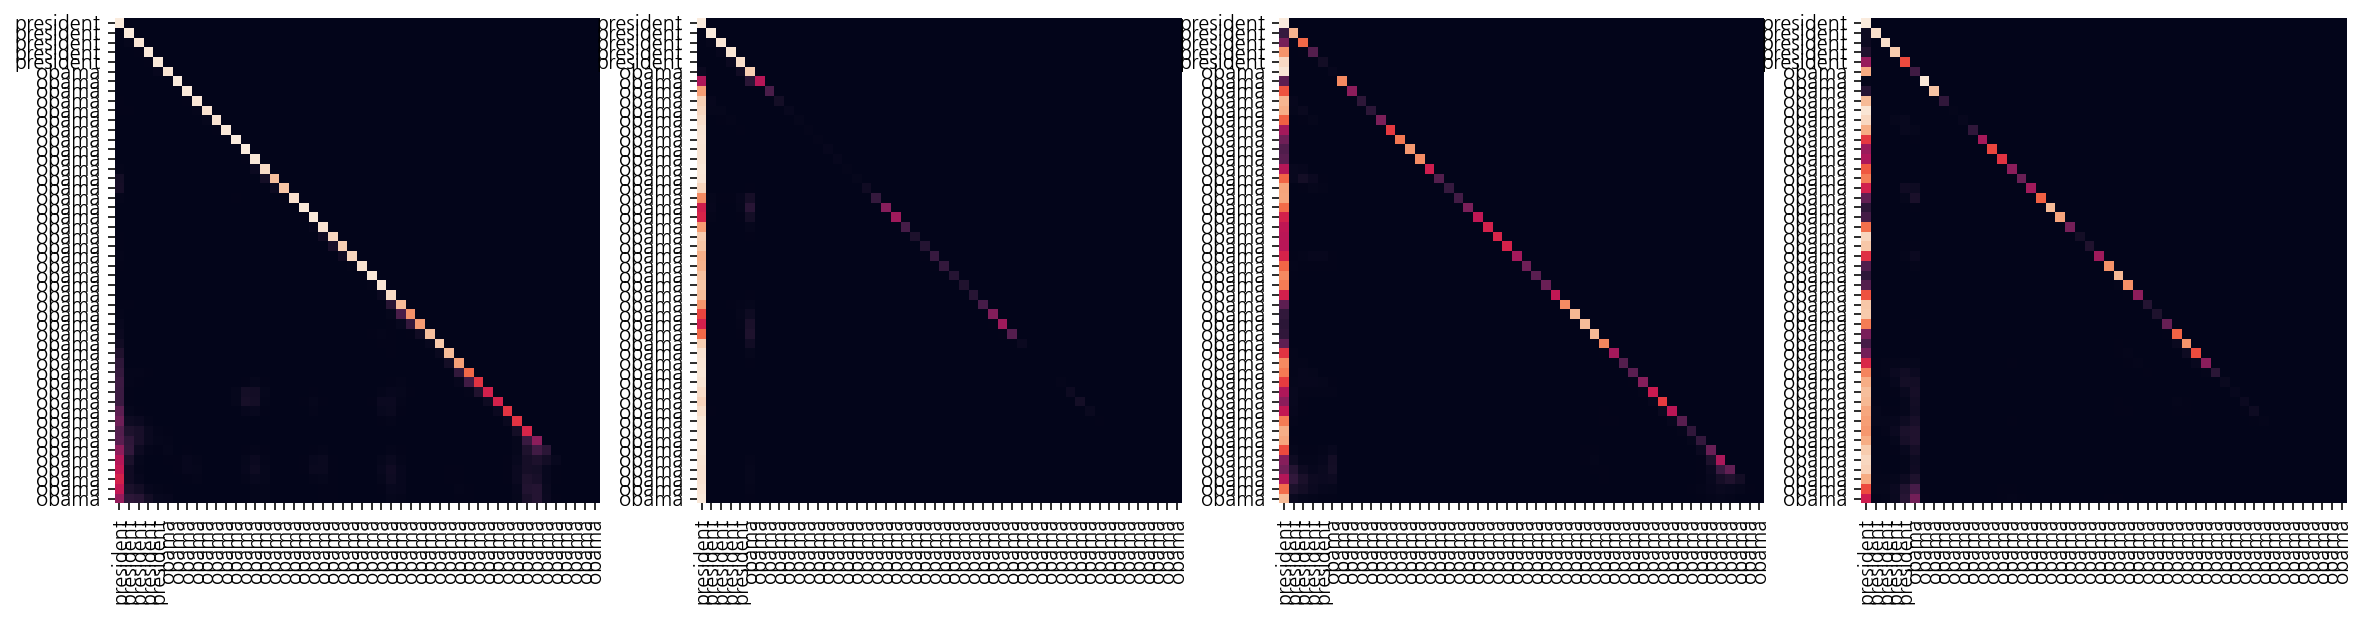

Decoder Src Layer 1


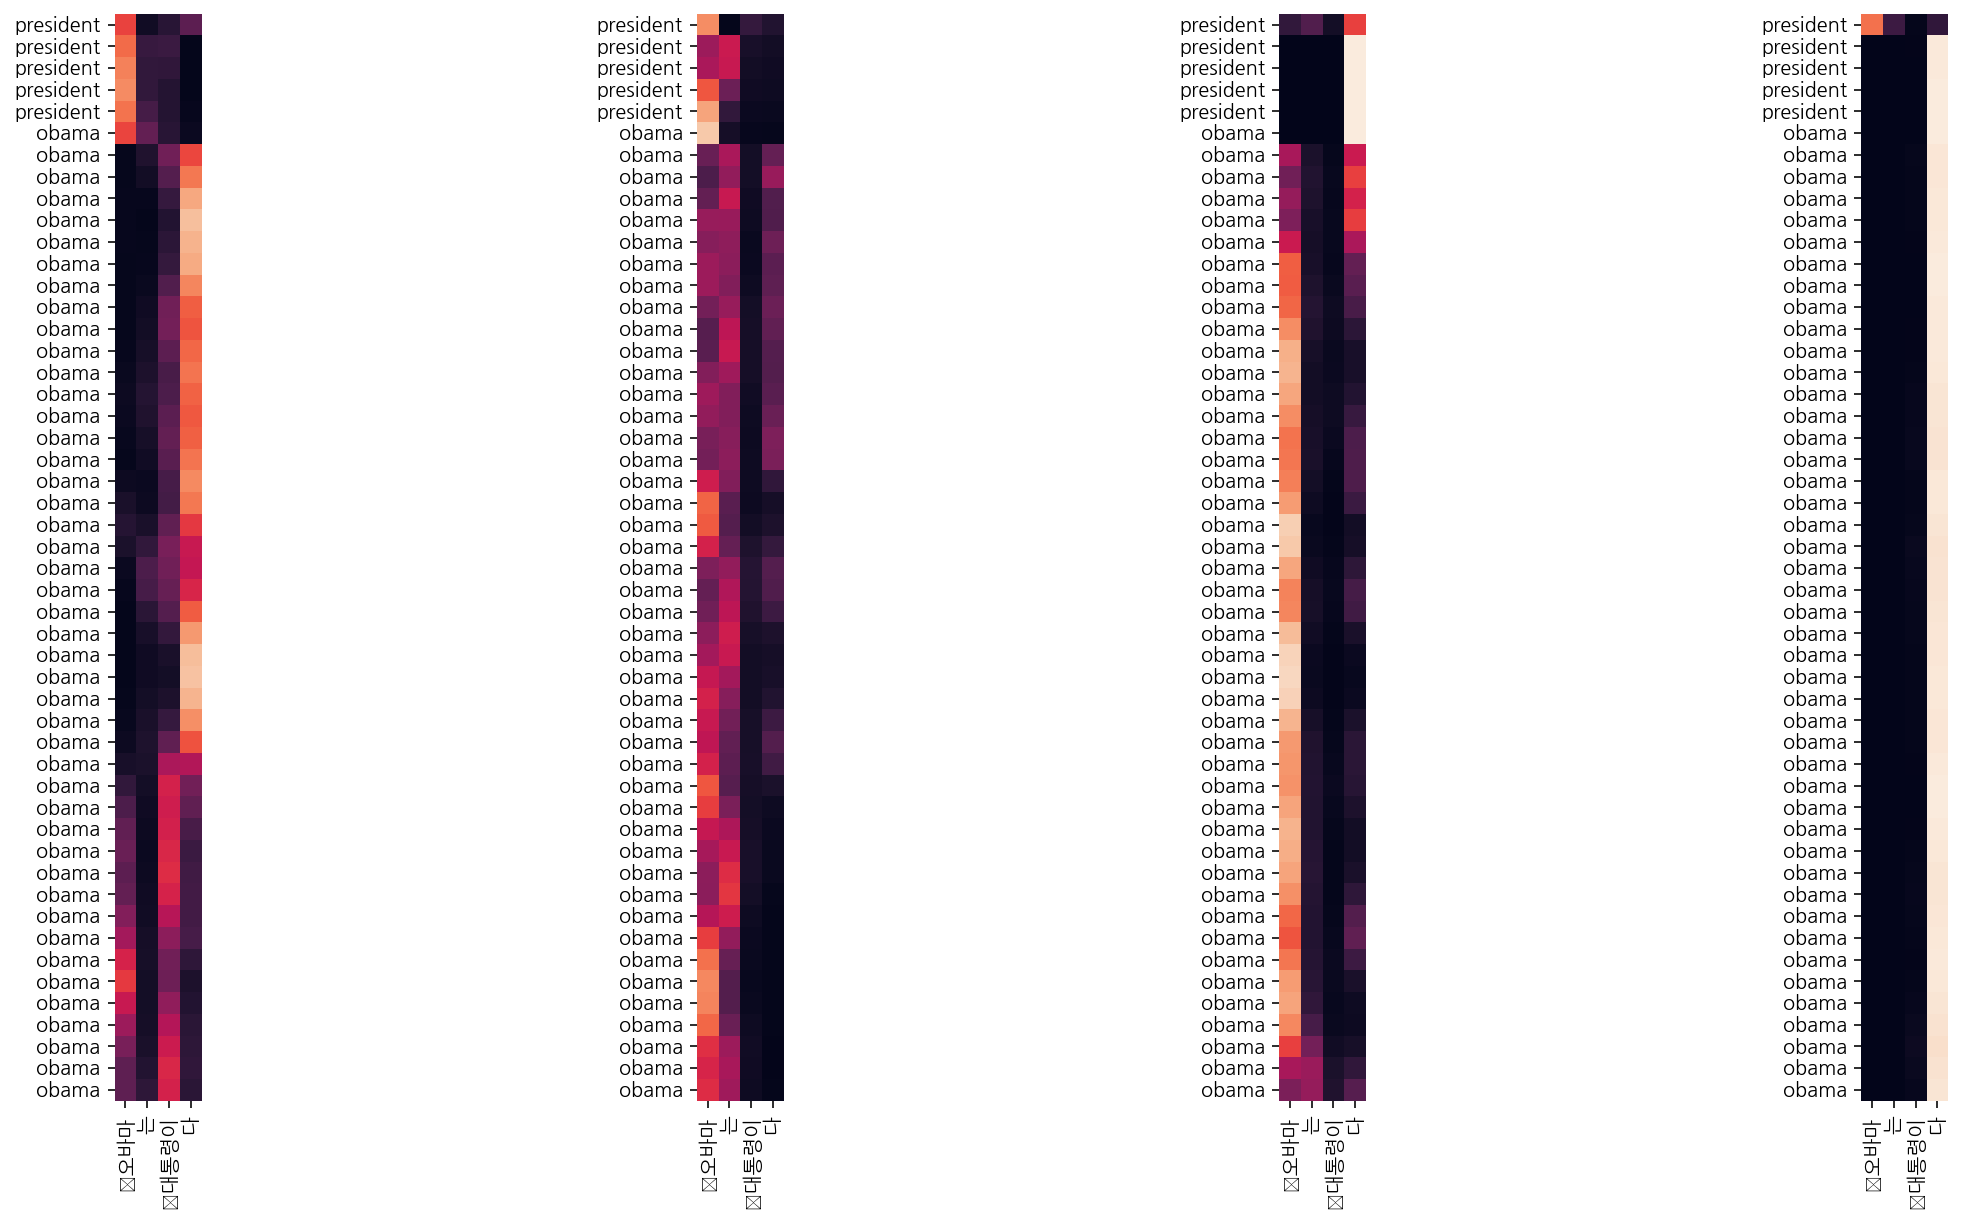

Decoder Self Layer 2


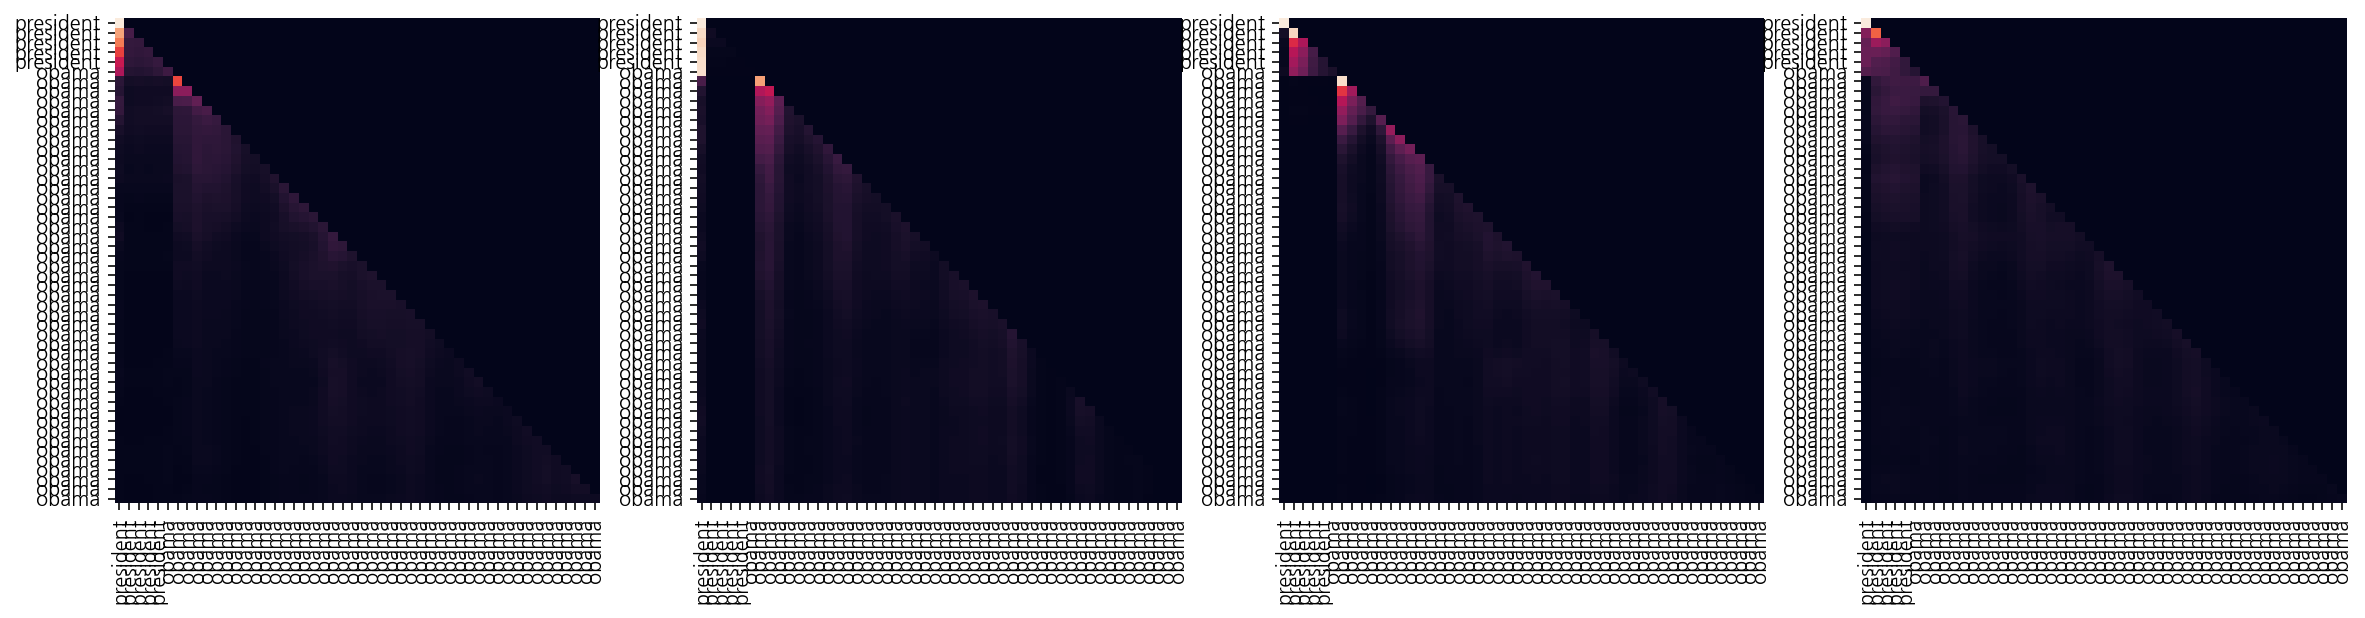

Decoder Src Layer 2


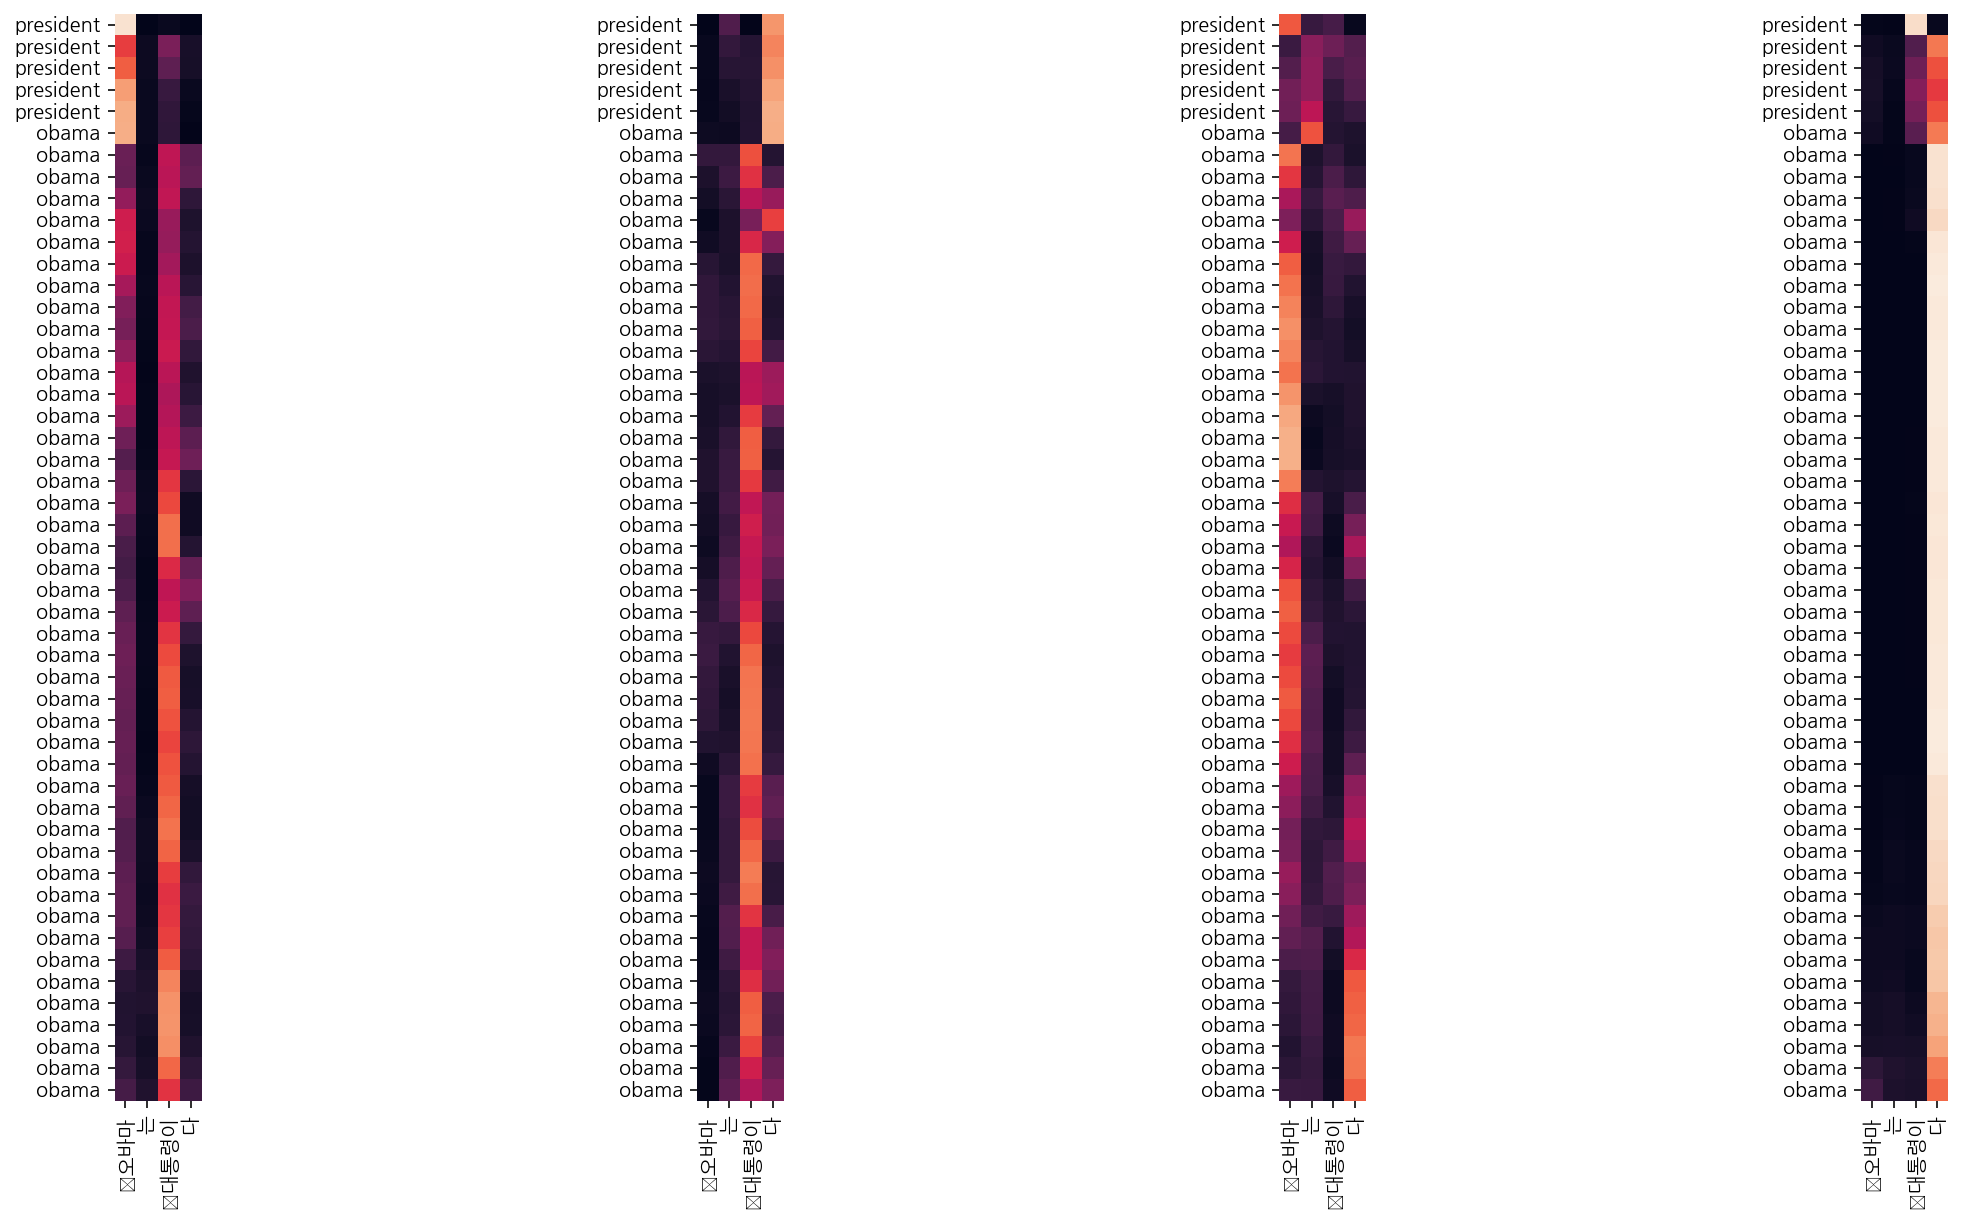

Input: 시민들은 도시 속에 산다.
Predicted translation: 
Encoder Layer 1


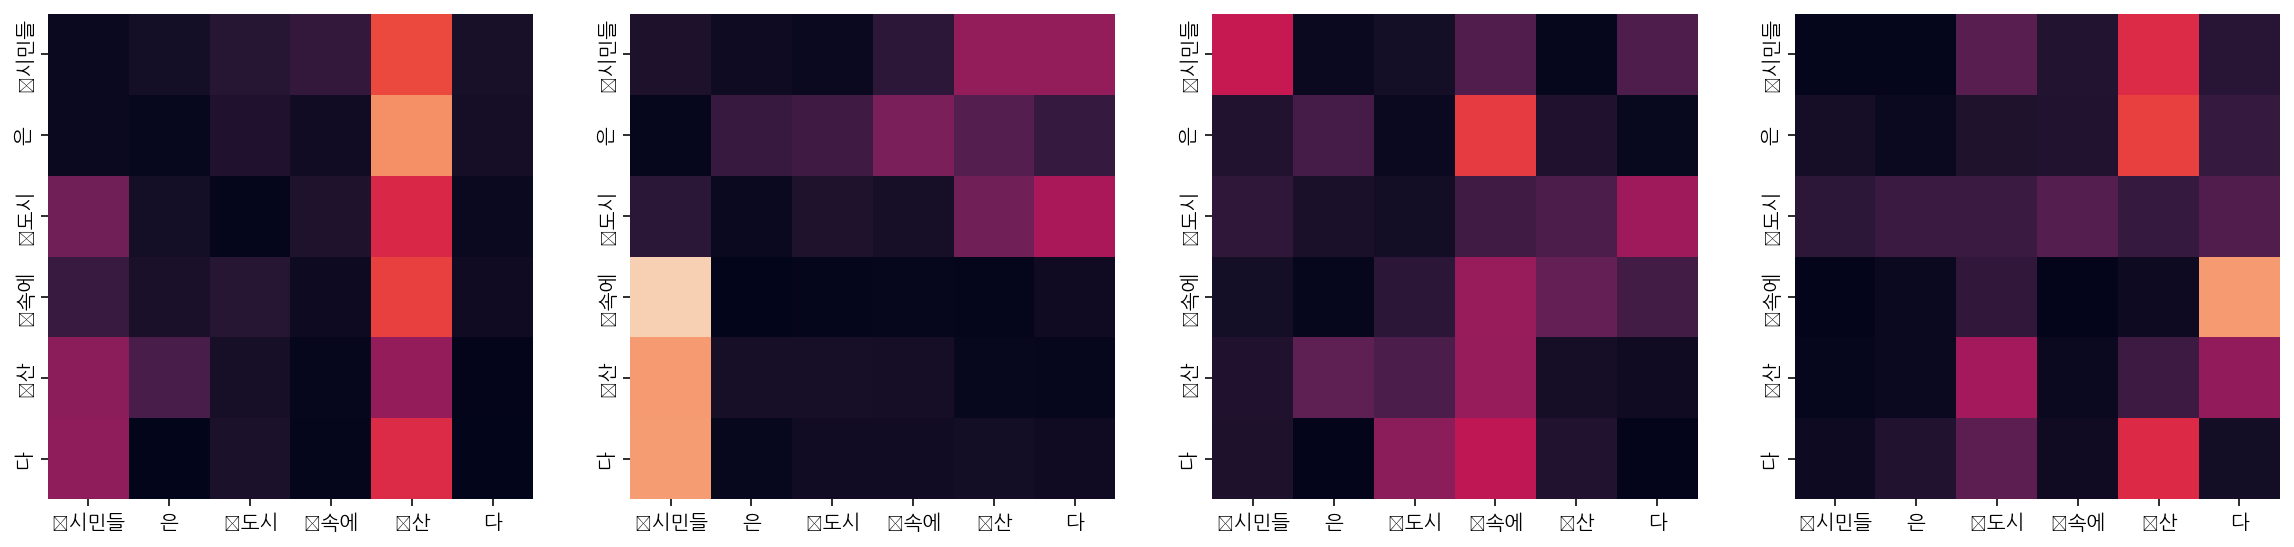

Encoder Layer 2


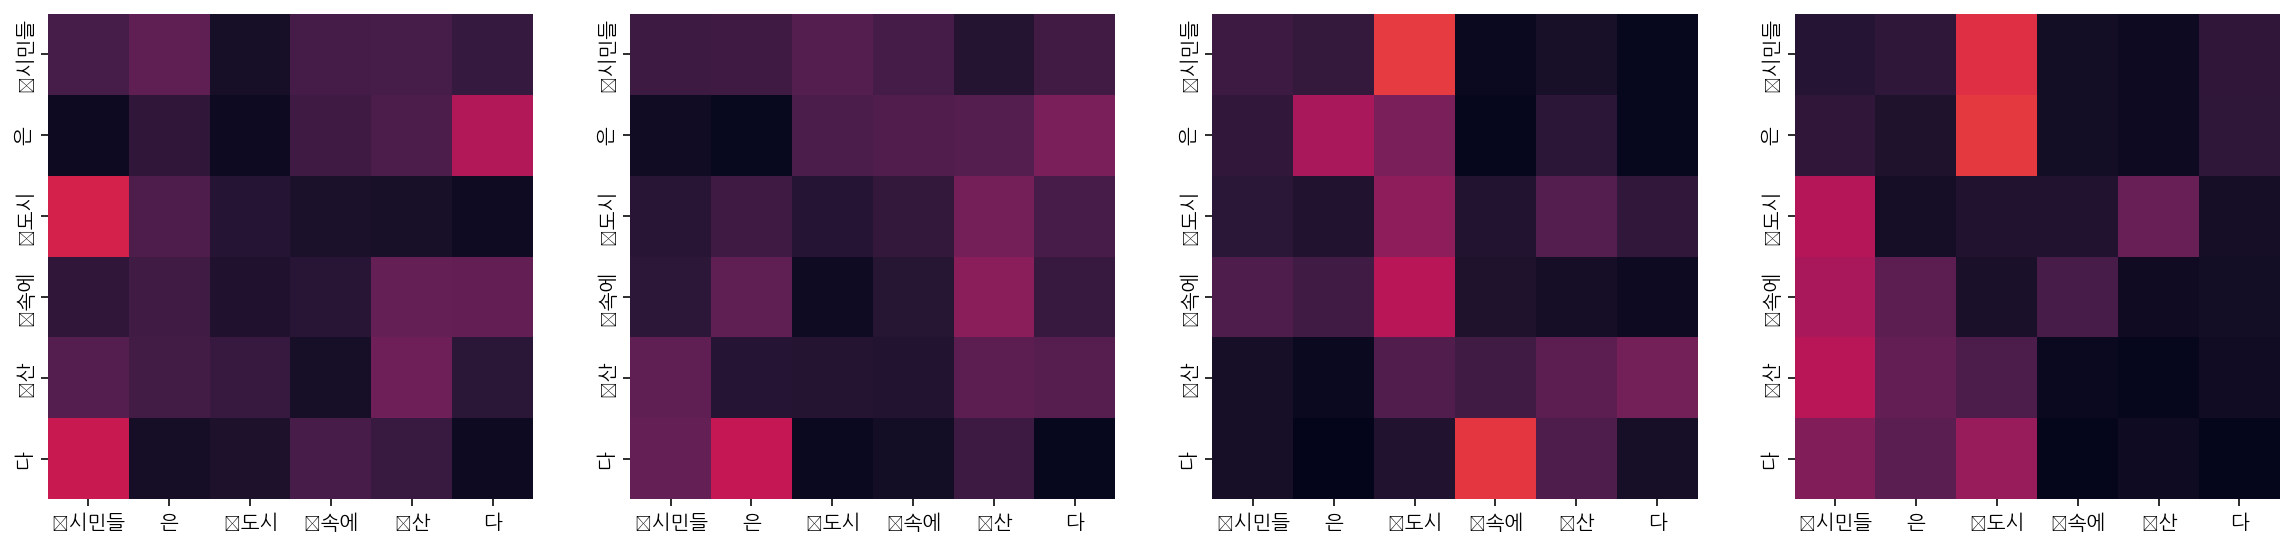

Decoder Self Layer 1


/opt/conda/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/opt/conda/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


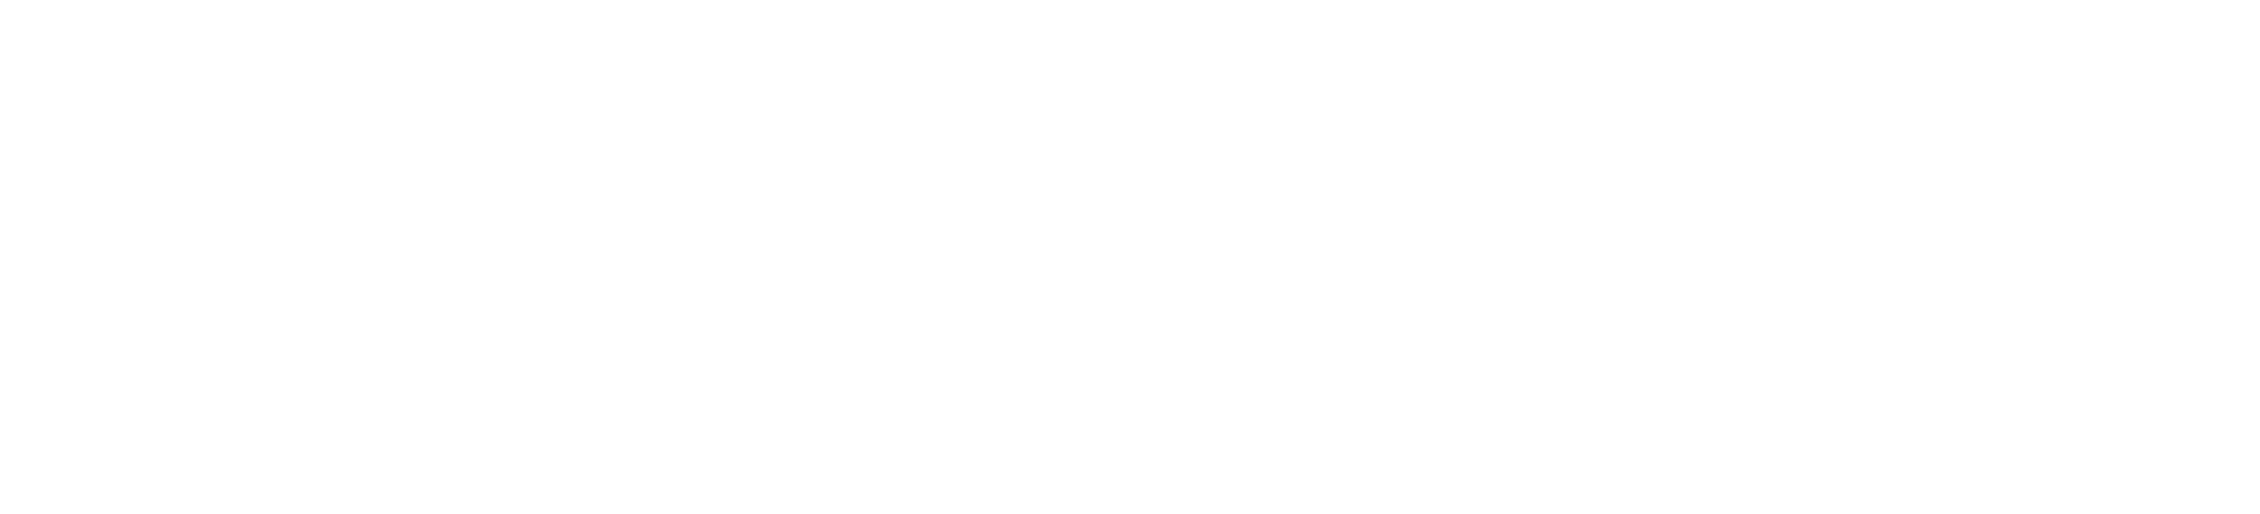

Decoder Src Layer 1


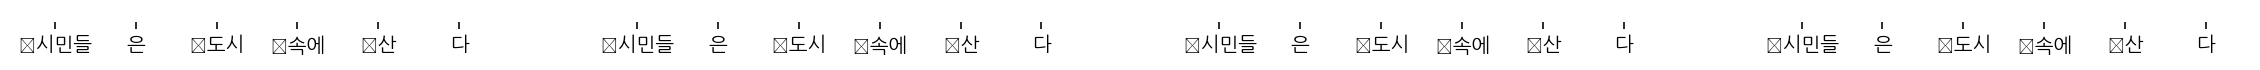

Decoder Self Layer 2


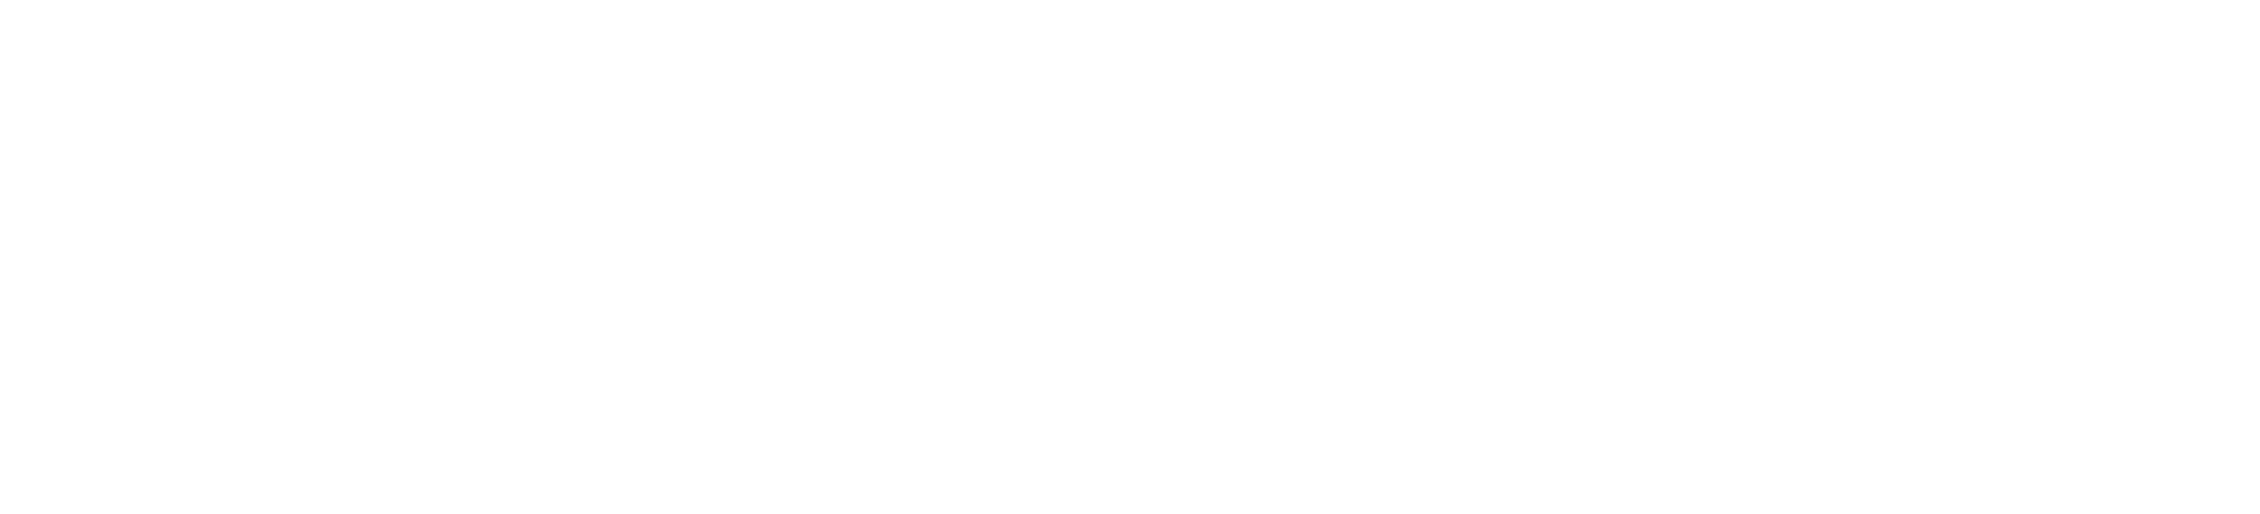

Decoder Src Layer 2


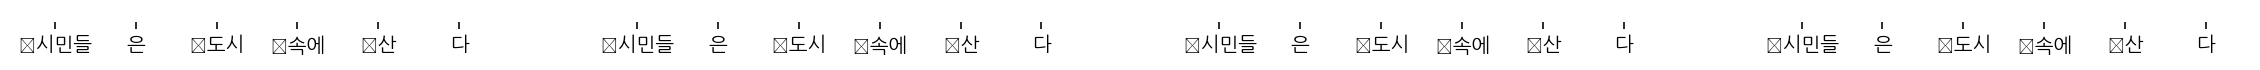

Input: 커피는 필요 없다.
Predicted translation: not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not but not but not
Encoder Layer 1


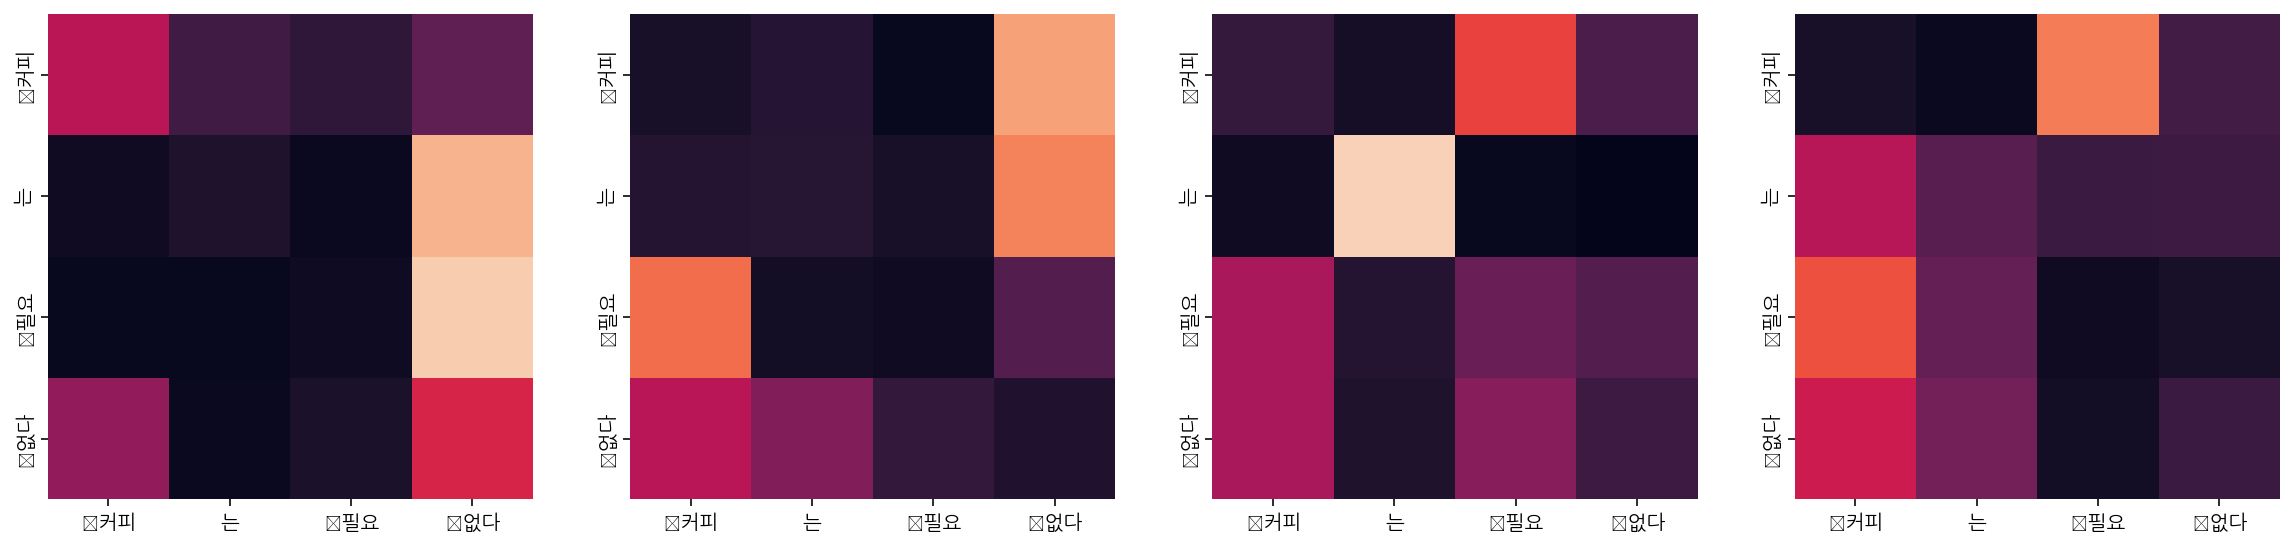

Encoder Layer 2


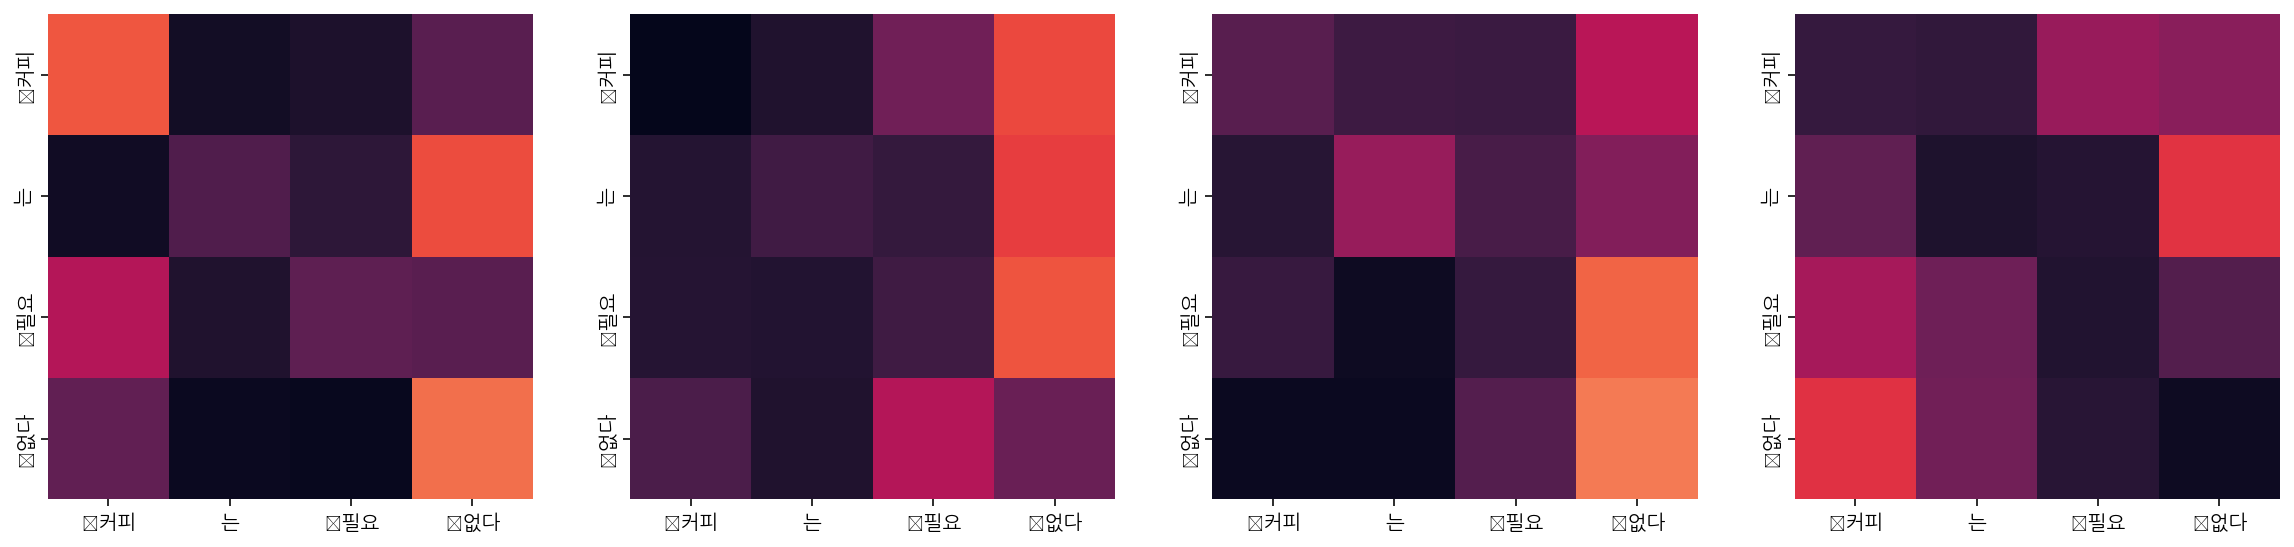

Decoder Self Layer 1


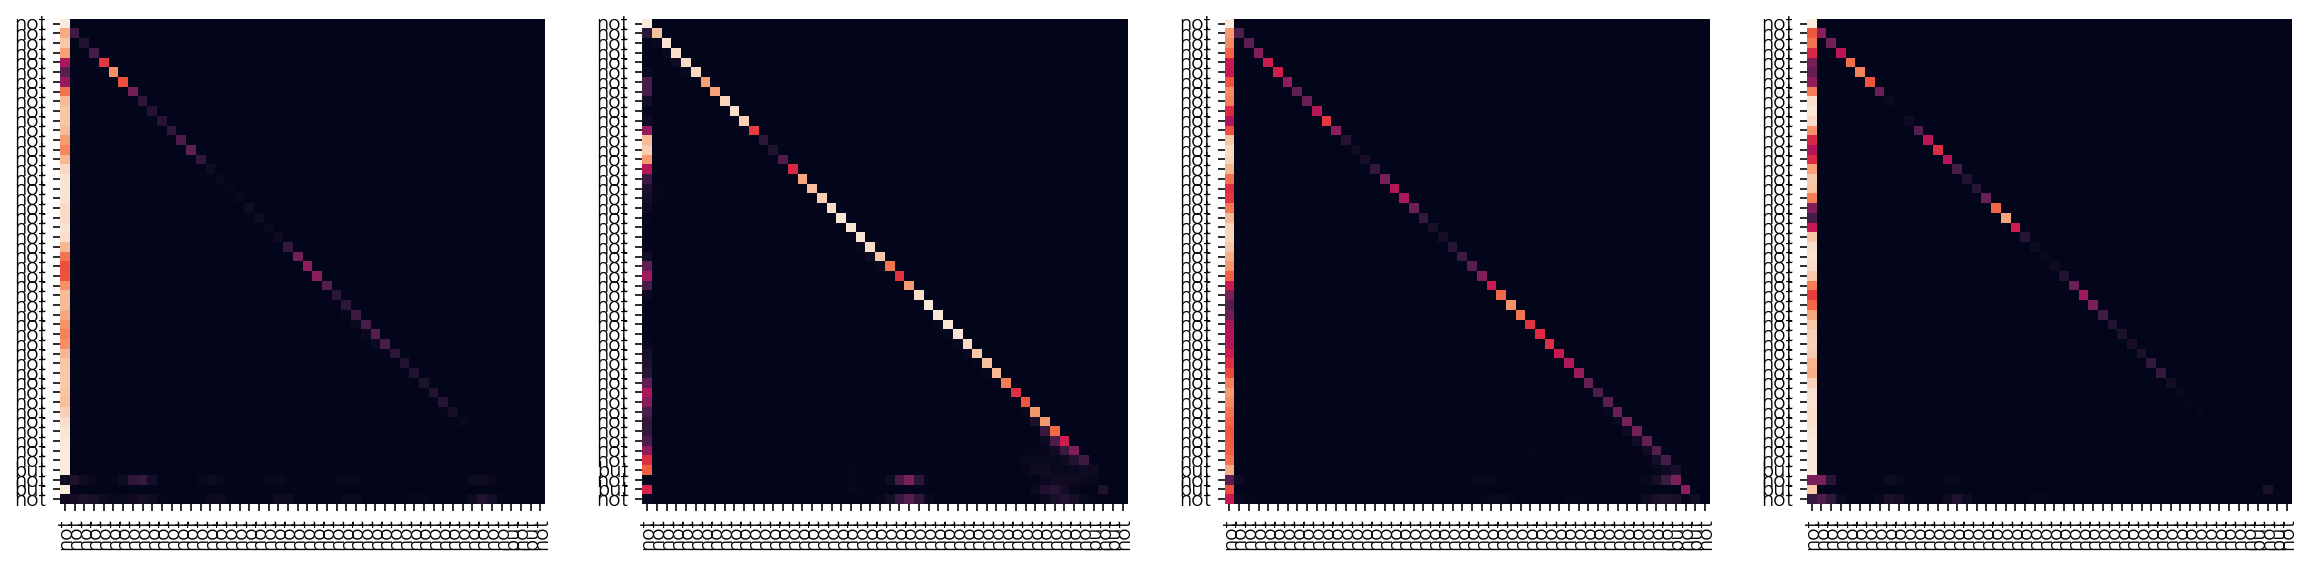

Decoder Src Layer 1


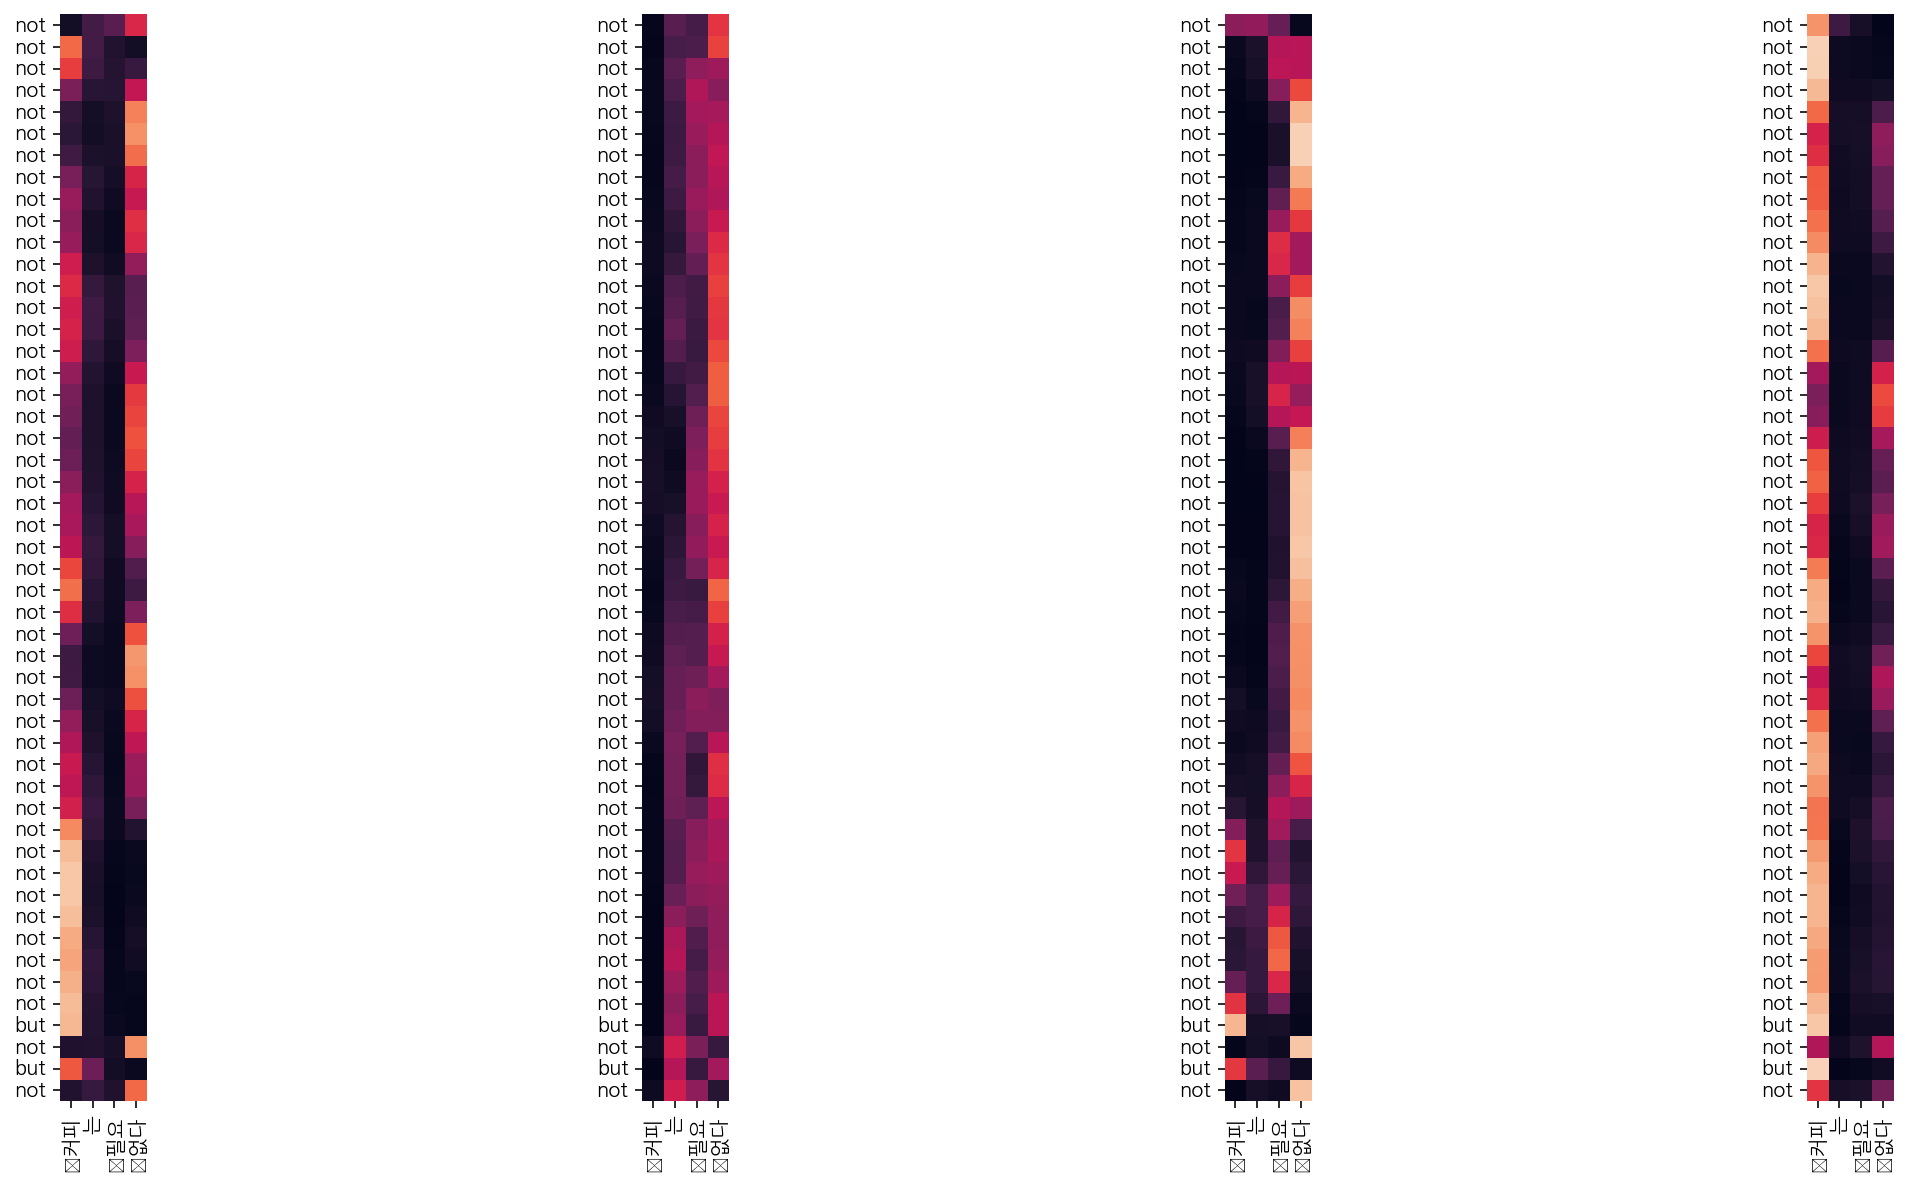

Decoder Self Layer 2


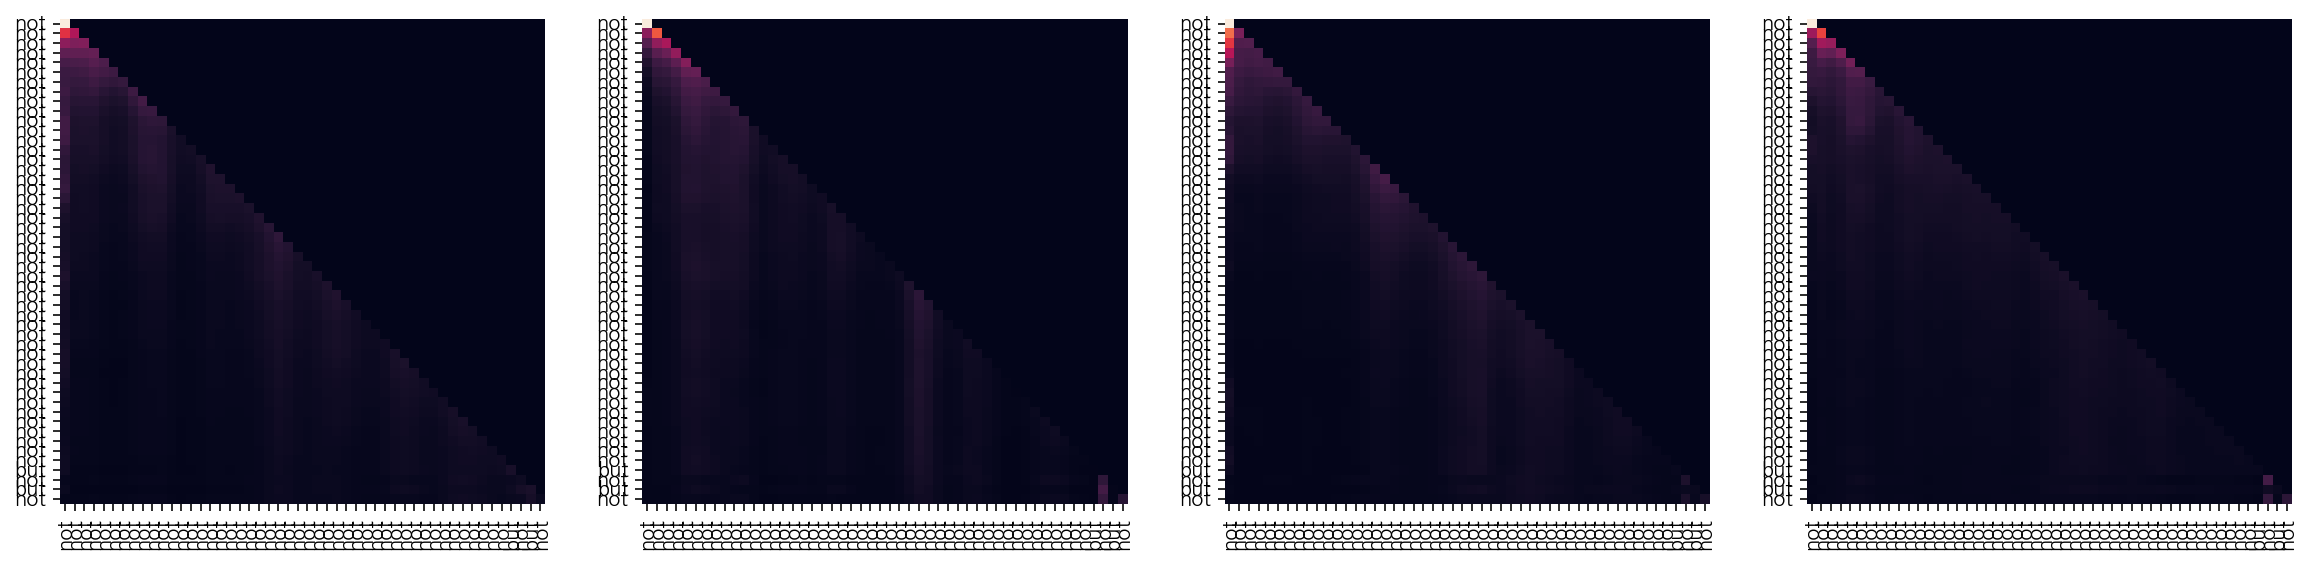

Decoder Src Layer 2


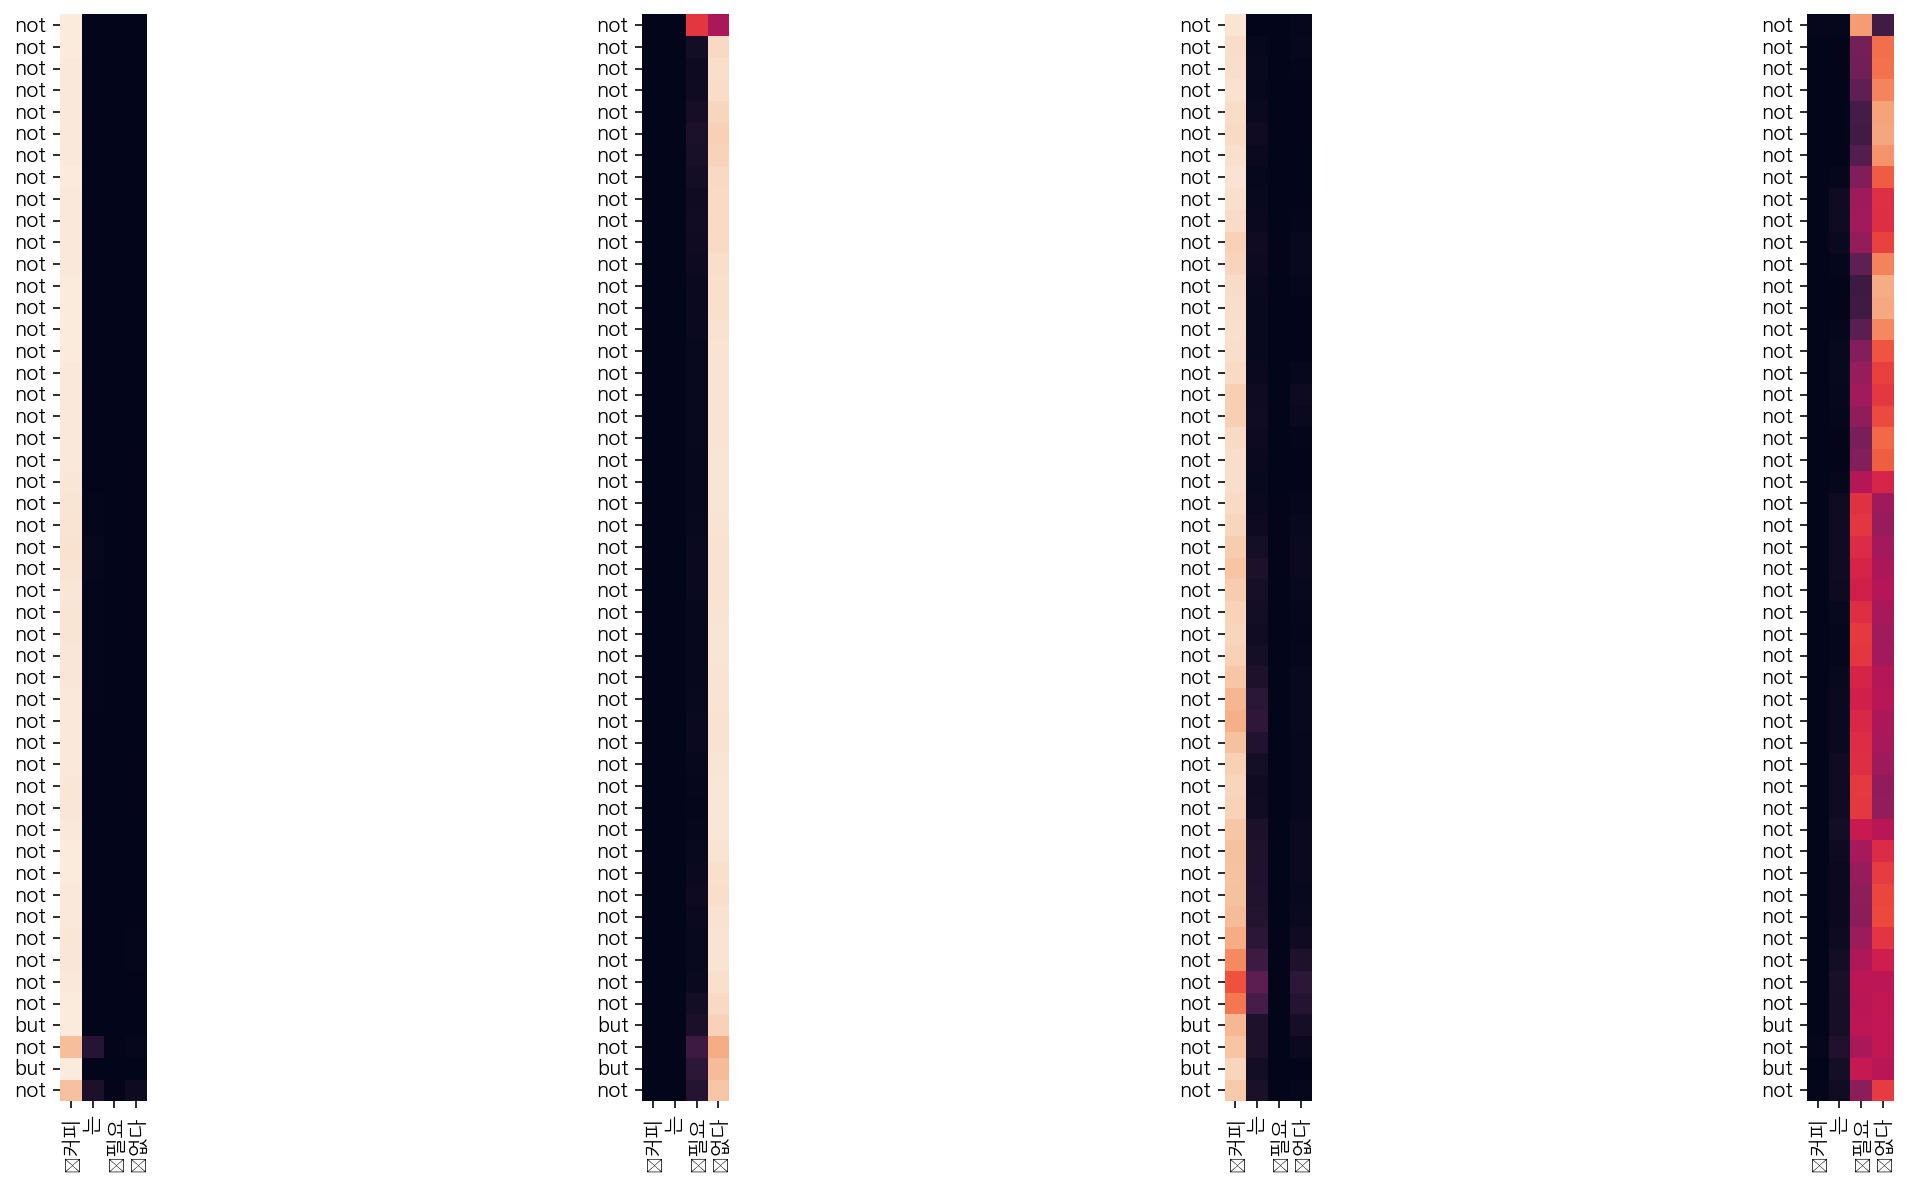

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 
Encoder Layer 1


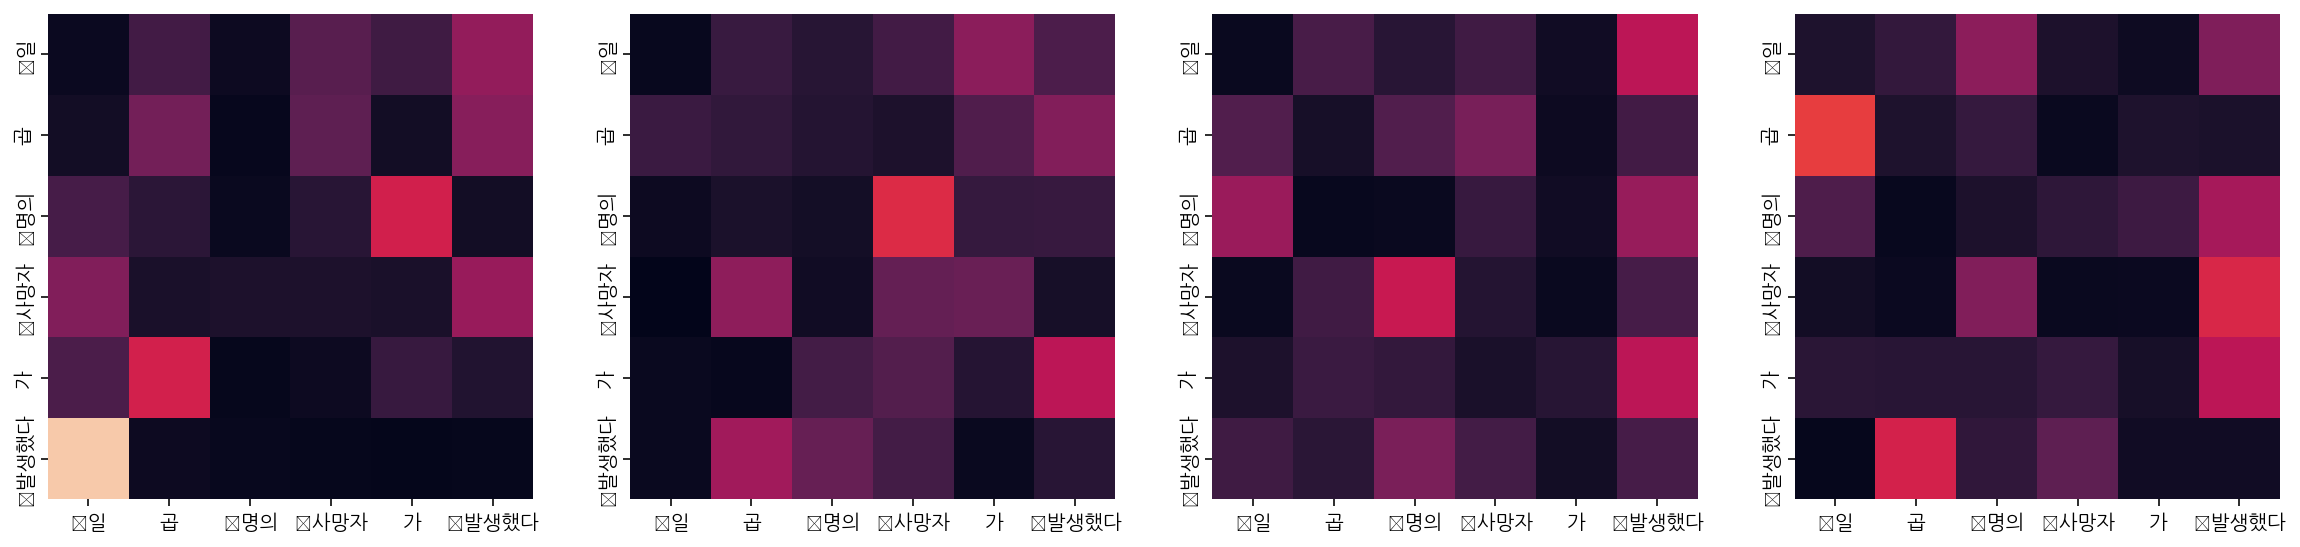

Encoder Layer 2


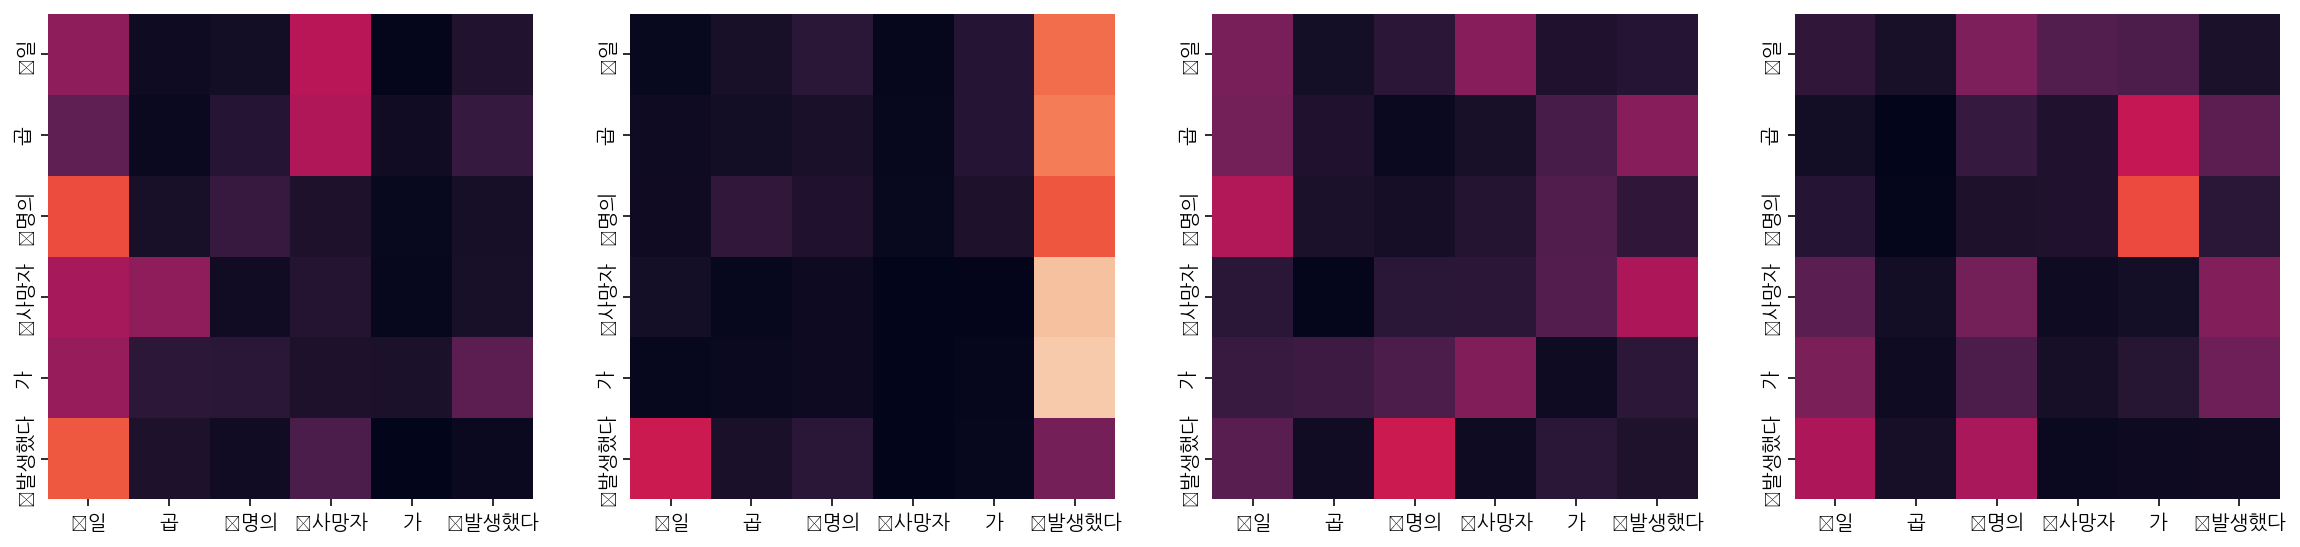

Decoder Self Layer 1


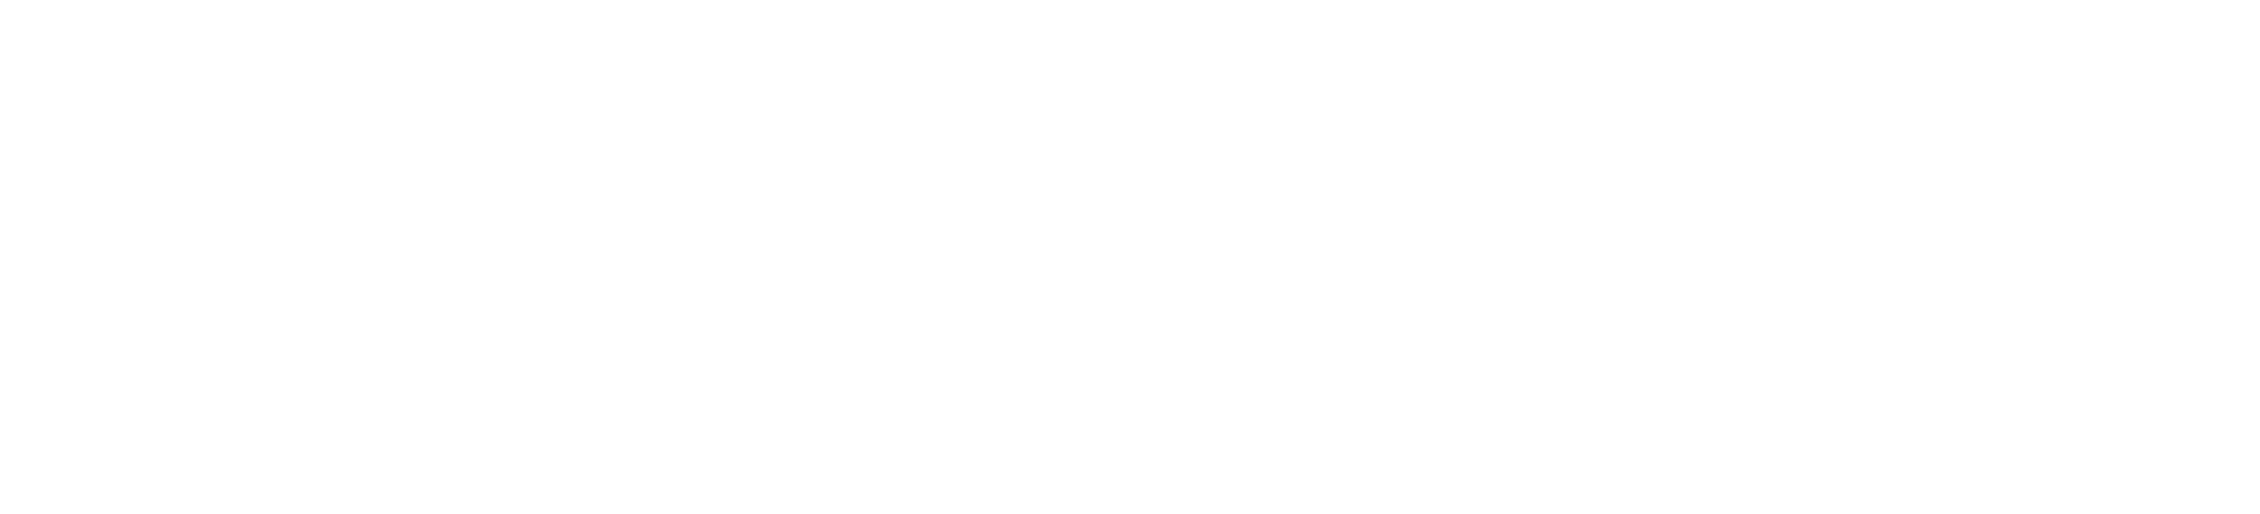

Decoder Src Layer 1


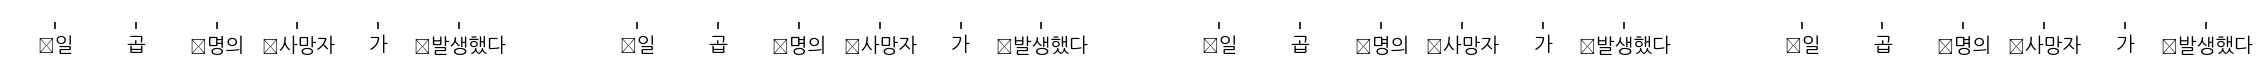

Decoder Self Layer 2


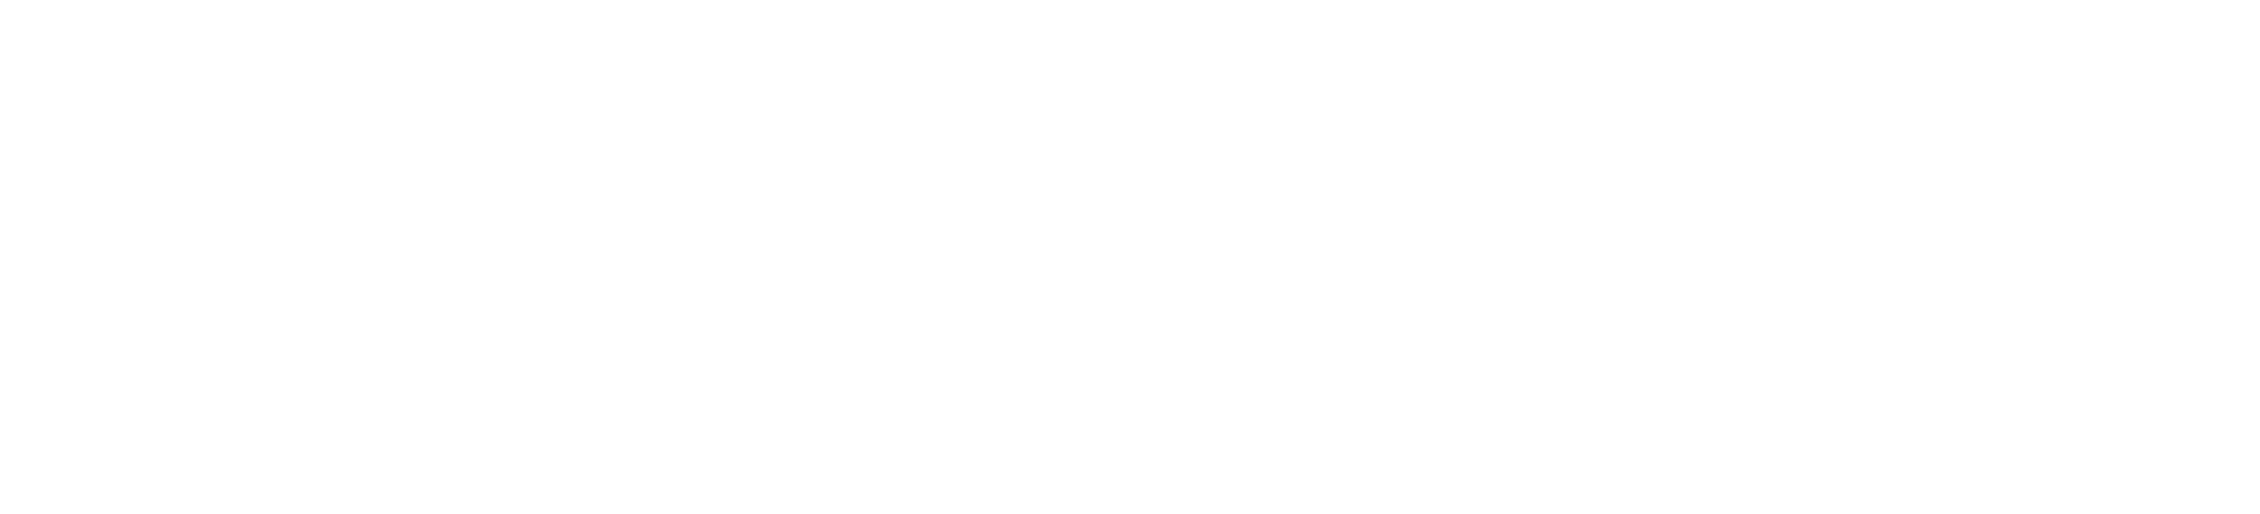

Decoder Src Layer 2


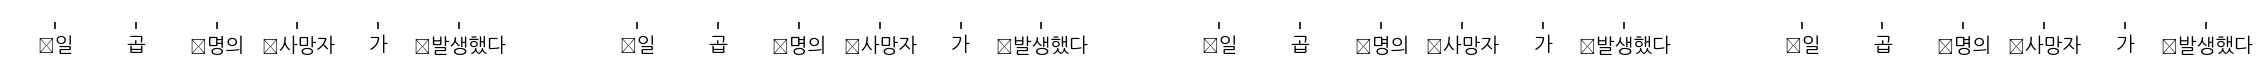

In [31]:
examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, True)

## 회 고


**첫 결과**

---
  * 영어 단어 하나만 생성 되는 결과
  
    ![first_result](./first_result.png)
    
  * SentencePiece의 단어장을 조회- '_오마마, _대통령, _대통령의' 
 
    ![s_p_vocab](./s_p_vocab.png)
    
  * 단어장에 존재 하는데 표현 하지 못하는 현상 
  
  * Attention Map을 보면 제대로 학습 되지 않는 것으로 보임
  


  
**개선 시도**

---
* Epoch을 1 --> 5 로 증가 후 진행 결과 -  ***Loss 0.5932*** 

  ![ephoch_5_loss](./ephoch_5_loss.png)
  
* 영어 단어 두개만 생성 되는 결과

  ![e_5_r](./ephoch_5_result.png)

**추가 확인**

---
 * 한글 토그나이저의 디코더 결과 공백
    ![k_t_e](./k_t_e.png)
    
**향후 개선 포인터**

 * 한글 토그나이저의 디코더 공백인 문장에 대한 추가 분석 후 진행 필요

---

***이전 seq2seq 프로젝트도 그렇고 모델 보다는 데이터 정제하고 토크나이저 부분에 대한 분석이 더 필요 한 것 같다.***

***이전 seq2seq 처럼 마스크에 의해 효과가 있을 거라고 판단 했으나, SentencePiece의 분석이 부족하여 만족할 만 결과가 나오지 않았다.***

***향후 개선 포인터를 중심으로 계속 진행 해 나갈 예정입니다.***
 